In [4]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
from WindPy import w

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from Util_Fin import easy_manager
# follow 20230614-国泰海通-大类资产配置量化模型研究系列之四：基于宏观因子的大类资产配置框架

import statsmodels.api  as sm 
from statsmodels.stats.outliers_influence  import variance_inflation_factor
 

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# PCA

In [105]:
'''
step 1:
选取合适的因子
先使用PCA的确定因子的范围,需要PCA的时序:
沪深300 - 000300.SH
中证500 - 000905.SH
国债 - 000012.SH
企业债 - 399481.SZ
南华商品 - NH0100.NHF
沪金 - AU9999.SGE
布伦特原油 - EBD:
'''
wsd_list = ['000300.SH','000905.SH','000012.SH','399481.SZ','NH0100.NHF','AU9999.SGE']
str = ','.join(wsd_list)
wsd_data = w.wsd(str,'close','2009-01-01','2022-12-31',usedf=True)[1]
edb_data = w.edb("S0260036", "2009-01-01", "2022-12-31","Fill=Previous",usedf=True)[1]
# wsd_data
# edb_data

In [106]:
price_data = pd.merge(wsd_data,edb_data,left_index=True,right_index=True)
price_data.columns = ['沪深300','中证500','国债','企业债','南华商品','沪金','布伦特原油']
price_data

,沪深300,中证500,国债,企业债,南华商品,沪金,布伦特原油
2009-01-12,1920.6870,2137.8410,121.1650,131.5850,954.8930,188.59,42.96
2009-01-13,1876.1850,2081.6720,121.1400,131.7000,928.8248,181.81,43.67
2009-01-14,1955.2440,2160.0640,120.9840,131.5010,956.9886,182.99,45.60
2009-01-15,1954.8740,2181.0610,120.8020,131.4530,942.0633,180.33,47.19
2009-01-16,1990.2140,2195.6340,120.7110,131.0790,958.1233,182.47,48.76
...,...,...,...,...,...,...,...
2022-12-26,3843.4887,5843.2555,198.4439,126.3299,2340.0500,407.53,84.62
2022-12-27,3887.8540,5885.6622,198.4789,126.3222,2373.7700,407.98,85.54
2022-12-28,3871.2644,5862.0967,198.4180,126.3236,2361.2300,408.99,82.96
2022-12-29,3856.7007,5857.4021,198.4806,126.3138,2356.4100,407.19,82.25


In [107]:
ret_data = price_data.pct_change().dropna()
ret_data

,沪深300,中证500,国债,企业债,南华商品,沪金,布伦特原油
2009-01-13,-0.023170,-0.026274,-0.000206,8.739598e-04,-0.027300,-0.035951,0.016527
2009-01-14,0.042138,0.037658,-0.001288,-1.511010e-03,0.030322,0.006490,0.044195
2009-01-15,-0.000189,0.009721,-0.001504,-3.650162e-04,-0.015596,-0.014536,0.034868
2009-01-16,0.018078,0.006682,-0.000753,-2.845123e-03,0.017048,0.011867,0.033270
2009-01-19,0.011180,-0.001288,-0.000422,1.022284e-03,0.002302,0.014961,-0.082034
...,...,...,...,...,...,...,...
2022-12-26,0.003989,0.013865,0.001135,-1.282192e-04,0.012855,-0.003667,0.001302
2022-12-27,0.011543,0.007257,0.000176,-6.095152e-05,0.014410,0.001104,0.010872
2022-12-28,-0.004267,-0.004004,-0.000307,1.108277e-05,-0.005283,0.002476,-0.030161
2022-12-29,-0.003762,-0.000801,0.000315,-7.757854e-05,-0.002041,-0.004401,-0.008558


In [108]:
from Util_Fin.PCAanalysis import PCAAnalyzer
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

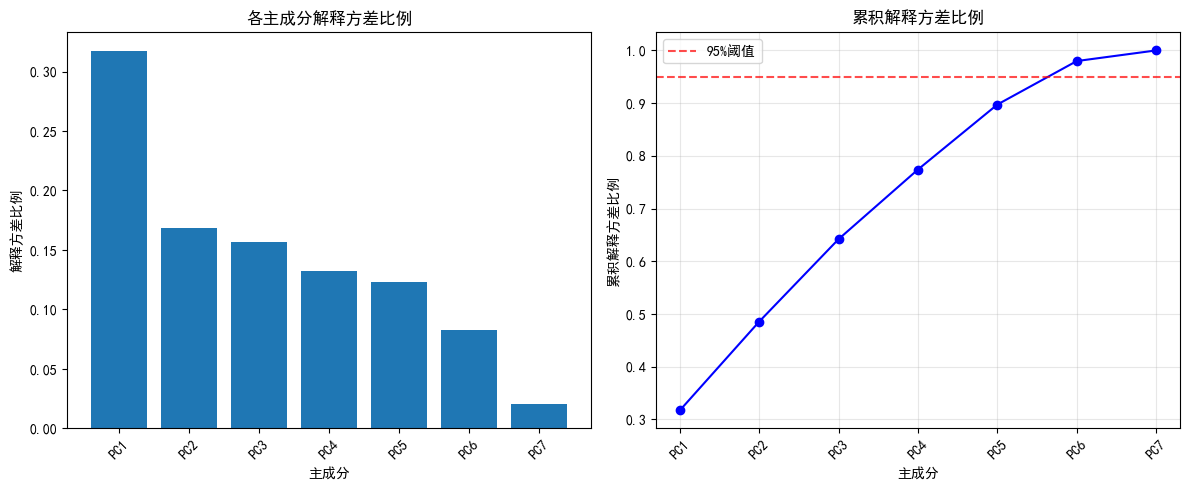

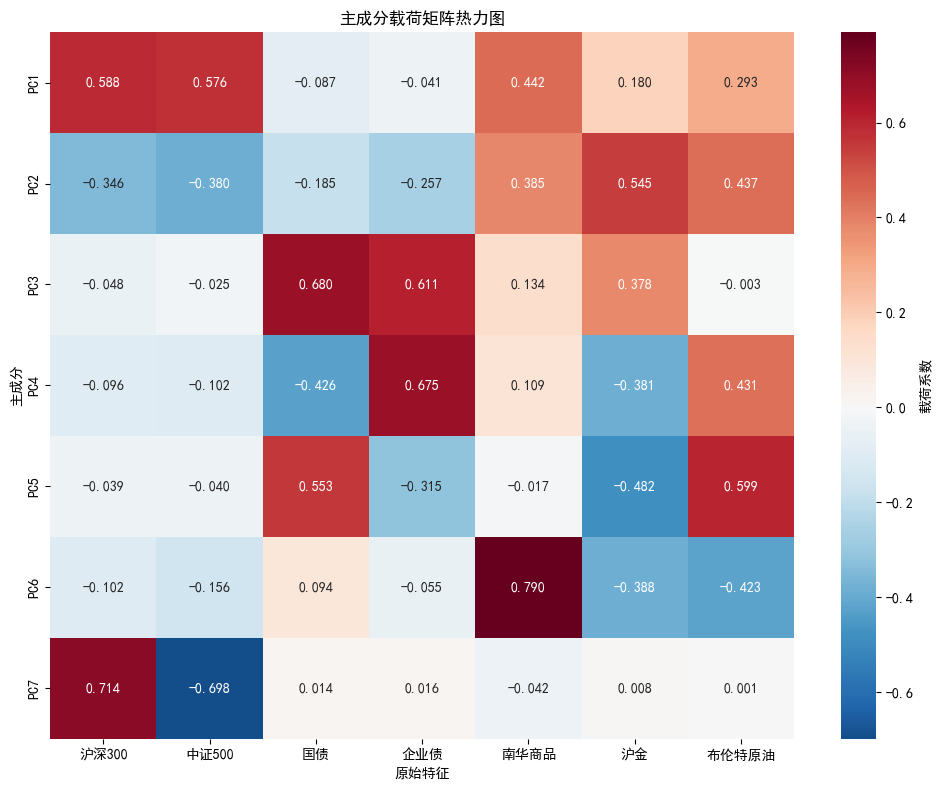

'\n分析各个主成分可以得到:\n第一主成分对应经济增长风险\n第二主成分对应利率风险\n第三主成分对应汇率风险\n第四主成分对应通胀风险\n第五主成分难以判断\n第六主成分对应信用风险\n第七主成分对应流动性风险\n'

In [109]:
pca_analyzer = PCAAnalyzer(standardize=True)
pca_analyzer.fit(ret_data)

# 获取分析结果
summary = pca_analyzer.get_summary_statistics()
components = pca_analyzer.get_components_matrix()

# 可视化
pca_analyzer.plot_explained_variance()
pca_analyzer.plot_components_heatmap()
'''
分析各个主成分可以得到:
第一主成分对应经济增长风险
第二主成分对应利率风险
第三主成分对应汇率风险
第四主成分对应通胀风险
第五主成分难以判断
第六主成分对应信用风险
第七主成分对应流动性风险
'''

# 低频因子构建

In [232]:
'''
PCA的结果并不稳定，其主要用途是用于确定宏观因子的数量与范围;
对于宏观资产的构造，在国外使用较多的是通过构造模拟资产的方式来拟合宏观指标。
因此在使用PCA找到原始宏观因子以后，我们需要做一下几点：
1. 寻找合适的的宏观经济原始指标
2. 选择资产组合来拟合原始经济指标
follow国泰海通，在经济原始指标选取中，考虑如下：
1.增长因子：考虑将PMI的同比差分(M0017126*)、
          固定资产投资额完成额同比(累计同比M0000273,累计值M0000272)、
          社会消费品零售总额同比(当月同比M0001428,累计同比M0001440)、
          进出口金额同比(当月同比M0000605,累计同比M0043657)四个同比指标根据波动率进行加权构造
2.通胀因子：使用CPI同比(当月同比M0000612,累计同比M0000729)和PPI同比(当月同比M0001227,累计同比M0001244)按波动率倒数进行加权构造
3.利率因子：使用10年期国债收益率(S0059749)表示
4.信用因子：使用3年期AA中短期票据收益率(S0059717)和3年期国开债收益率(M1004265)的差来刻画信用利差的变化
5.汇率因子：使用美元指数(M0000271)来代替汇率因子
6.流动性因子：使用M2同比(M0001385)和社融存量同比(M5525763)的差来构造
'''
macro_data = w.edb("M0017126,M0000272,M0000273,M0001428,M0001440,M0000605,M0043657,M0000612,M0001227,M0001244,M0000729,S0059749,S0059717,M1004265,M0000271,M0001385,M5525763",
                    "2005-01-30", 
                    "2025-11-18",
                    "Fill=Previous",
                    "Period=M",
                    usedf=True)[1]
# with easy_manager.EasyManager(database='macro_data_base') as em:
#     macro_data = em.load_table('raw_macro_data_m',order_by='index',ascending=True)
#     macro_data.set_index('index',inplace=True)

In [271]:
macro_data.index=pd.to_datetime(macro_data.index)
macro_data['delta_M0017126'] = macro_data['M0017126'].diff(12)
macro_data_M = macro_data.resample('M').last().dropna(how='all')
#处理当月同比固定资产完成额
sub = macro_data_M[['M0000272','M0000273']]
sub.loc[(sub.index.month == 1),['M0000272']] = np.nan
sub.fillna(method='bfill',inplace=True)
sub.loc[(sub.index.month == 1),['M0000272']] = (sub.loc[(sub.index.month == 1),['M0000272']]/2)
sub['lag_M0000272']=(sub.groupby(sub.index.year).shift(1))['M0000272']
sub.loc[(sub.index.month == 1),['lag_M0000272']] = 0
sub['delta_M0000272'] = sub['M0000272'] - sub['lag_M0000272']
sub['yoy_M0000272'] = sub['delta_M0000272'].pct_change(12)
macro_data_M['yoy_M0000272'] = sub['yoy_M0000272']*100
macro_data_M = macro_data_M.iloc[:-1]

In [272]:
sub.tail(20)

,M0000272,M0000273,lag_M0000272,delta_M0000272,yoy_M0000272
2024-04-30,143401.0,4.2,100042.0,43359.0,0.078582
2024-05-31,188006.0,4.0,143401.0,44605.0,0.079162
2024-06-30,245391.0,3.9,188006.0,57385.0,0.056853
2024-07-31,287611.0,3.6,245391.0,42220.0,-0.013206
2024-08-31,329385.0,3.4,287611.0,41774.0,0.015312
2024-09-30,378978.0,3.4,329385.0,49593.0,0.033338
2024-10-31,423222.0,3.4,378978.0,44244.0,-0.002930
2024-11-30,465839.0,3.3,423222.0,42617.0,0.029272
2024-12-31,514374.0,3.2,465839.0,48535.0,0.149519
2025-01-31,26309.5,3.2,0.0,26309.5,0.034850


In [265]:
macro_data_M

,M0017126,M0000272,M0000273,M0001428,M0001440,M0000605,M0043657,M0000612,M0001227,M0001244,M0000729,S0059749,S0059717,M1004265,M0000271,M0001385,M5525763,delta_M0017126,yoy_M0000272
2005-01-31,54.7,NaN,NaN,11.5,11.5,33.0,33.0,1.9,5.80,5.8,1.9,4.8982,NaN,3.6478,83.6000,14.13,NaN,NaN,NaN
2005-02-28,54.5,4221.78,24.5,15.8,13.6,10.7,21.5,3.9,5.38,5.6,2.9,4.8334,NaN,3.2747,82.5100,13.90,NaN,NaN,NaN
2005-03-31,57.9,9036.68,25.3,13.9,13.7,25.7,23.1,2.7,5.60,5.6,2.8,4.1203,NaN,3.3355,84.0600,14.00,NaN,NaN,NaN
2005-04-30,56.7,14024.67,25.7,12.2,13.3,23.9,23.3,1.8,5.78,5.7,2.6,4.0441,NaN,2.8180,84.4300,14.10,NaN,NaN,NaN
2005-05-31,52.9,19719.32,26.4,12.8,13.2,22.8,23.2,1.8,5.90,5.7,2.4,3.8469,NaN,2.6853,87.7600,14.60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,49.7,248654.00,2.8,4.8,5.0,3.9,1.7,0.1,-3.60,-2.8,-0.1,1.6469,2.0439,1.5807,96.7723,8.30,8.9,-0.1,-1.181493
2025-07-31,49.3,288229.00,1.6,3.7,4.8,5.8,2.3,0.0,-3.60,-2.9,-0.1,1.7044,2.0899,1.6400,100.0489,8.80,9.0,-0.8,-6.264803
2025-08-31,49.4,326111.00,0.5,3.4,4.6,3.1,2.4,-0.4,-2.90,-2.9,-0.1,1.8379,2.0941,1.6916,97.8477,8.80,8.8,-0.9,-9.316800
2025-09-30,49.8,371535.00,-0.5,3.0,4.5,7.9,3.1,-0.3,-2.30,-2.8,-0.1,1.8605,2.1969,1.7796,97.8224,8.40,8.7,-0.3,-8.406428


In [284]:
Growth*weight

,delta_M0017126,M0000273,M0001428,M0000605
2006-11-30,0.471558,4.235982,3.474112,2.789159
2006-12-31,0.156425,4.137311,3.602792,2.775755
2007-01-31,0.055052,4.077497,3.718145,2.780924
2007-02-28,0.301777,4.077373,3.791950,2.700943
2007-03-31,0.731112,4.136724,3.812588,2.551026
...,...,...,...,...
2025-06-30,-0.095195,0.441294,1.162821,0.438915
2025-07-31,-0.207949,0.286138,1.027819,0.481133
2025-08-31,-0.298688,0.110464,0.891621,0.474475
2025-09-30,-0.371984,-0.074691,0.766735,0.422893


<Axes: >

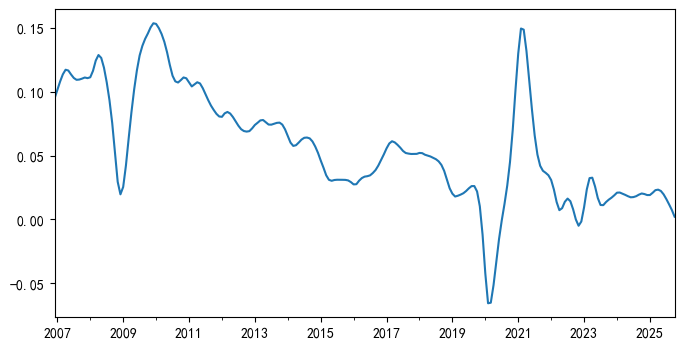

In [288]:
#增长因子
from statsmodels.tsa.filters.hp_filter  import hpfilter
Growth = macro_data_M[['delta_M0017126','M0000273','M0001428','M0000605']]
'''
Growh数据需要处理一月二月数据合并导致的缺失数据
'''
Growth.loc[(Growth.index.month == 1),['M0000273','M0001428']] = np.nan
Growth.fillna(Growth.interpolate(),inplace=True)

Growth = Growth.loc["2006-12-01":]
Growth_Dup = Growth.copy()

lambda_param = 4  # 根据数据频率调整
for column in Growth.columns: 
    # 提取序列 
    series = Growth[column]
    # 应用HP滤波 
    cycle, trend = hpfilter(series, lamb=lambda_param)
    # 将结果添加到DataFrame 
    Growth[f'{column}'] = trend
weight = ((1/Growth_Dup.std()))/((1/Growth_Dup.std()).sum())
Growth_f = ((weight*Growth).sum(axis=1)/100)
Growth_f.plot(figsize=(8,4))

<Axes: >

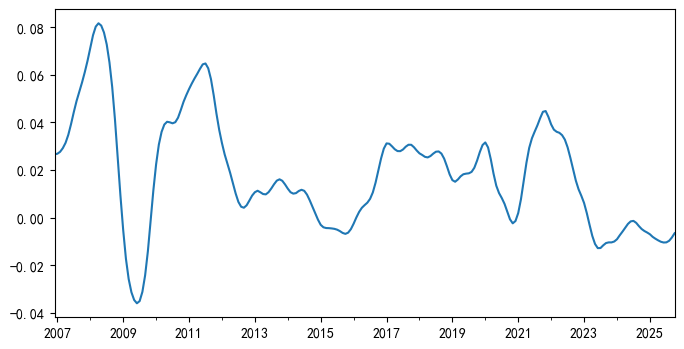

In [290]:
#通胀因子
Inflation = macro_data_M[['M0000612','M0001227']].loc['2006-12-31':]
lambda_param = 4  # 根据数据频率调整
for column in Inflation.columns: 
    # 提取序列 
    series = Inflation[column]
    # 应用HP滤波 
    cycle, trend = hpfilter(series, lamb=lambda_param)
    # 将结果添加到DataFrame 
    Inflation[f'{column}'] = trend
weight = (1/(Inflation.std()))/(1/(Inflation.std())).sum()
Inflation_f = ((weight*Inflation).sum(axis=1)/100)
Inflation_f.plot(figsize=(8,4))

<Axes: >

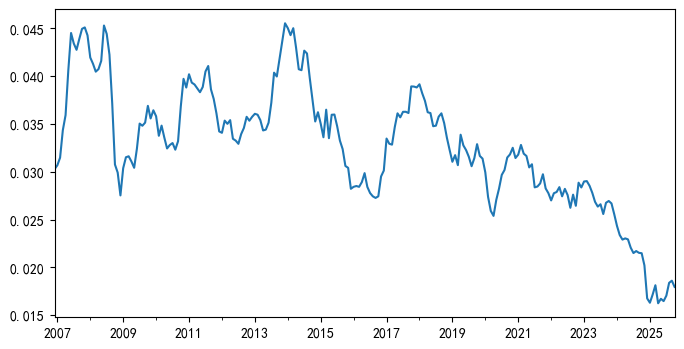

In [291]:
#利率因子
Intr = macro_data_M['S0059749'].loc['2006-12-31':]
Intr_f = Intr/100
Intr_f.plot(figsize=(8,4))

<Axes: >

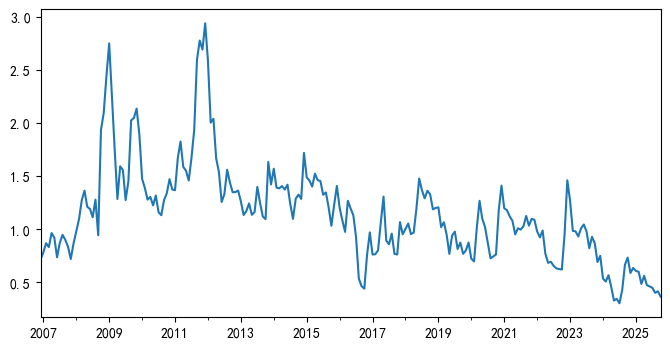

In [292]:
#信用因子
Credit = macro_data_M[['S0059717','M1004265']]
Credit.loc['2006-12-23':"2008-04-22",'S0059717',] = np.nan
linear_value = np.linspace(Credit.loc['2006-11-30','S0059717'], Credit.loc['2008-04-30','S0059717'], len(Credit['2006-11-30':'2008-04-30']))
Credit.loc['2006-12-23':"2008-04-22",'S0059717',] = linear_value[1:-1]
Credit_f = (Credit['S0059717'] - Credit['M1004265']).loc['2006-12-30':]
Credit_f.plot(figsize=(8,4))

<Axes: >

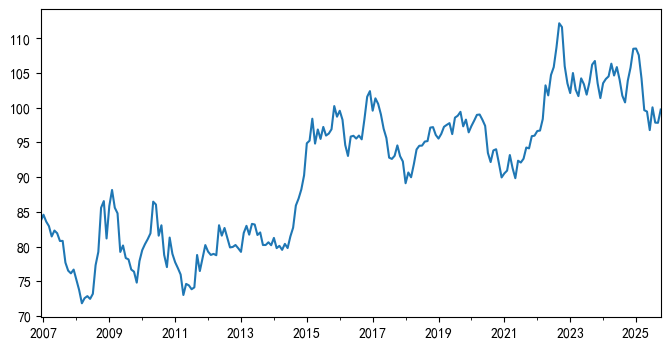

In [293]:
#汇率因子
exchange = macro_data_M['M0000271'].loc['2006-12-31':]
exchange_f = exchange
exchange_f.plot(figsize=(8,4))

<Axes: >

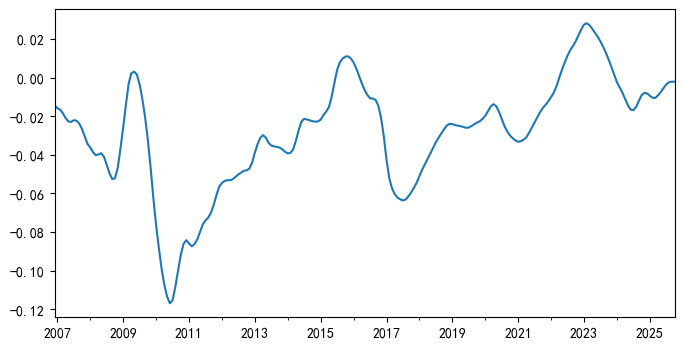

In [325]:
#流动性因子
liquidity = macro_data_M[['M0001385', 'M5525763']].loc['2006-12-31':]
k = (liquidity.loc["2006-12-31":"2014-12-31"]['M5525763'])
k.loc[k.index.month != 12] = np.nan
k = k.interpolate()
liquidity.update(k)
j = (liquidity.loc["2014-12-31":"2015-12-31"]['M5525763'])
j.loc[~j.index.month.isin([12,3,6,9])] = np.nan
j = j.interpolate()
liquidity.update(j)
lambda_param = 3  # 根据数据频率调整
for column in liquidity.columns: 
    # 提取序列 
    series = liquidity[column]
    # 应用HP滤波 
    cycle, trend = hpfilter(series, lamb=lambda_param)
    # 将结果添加到DataFrame 
    liquidity [f'{column}'] = trend
liquidity_f = (liquidity['M0001385'] - liquidity['M5525763'])/100
liquidity_f.plot(figsize=(8,4))


In [326]:
Macro_raw_factor = pd.concat([Growth_f,Inflation_f,Intr_f,Credit_f,exchange_f,liquidity_f], axis=1)
Macro_raw_factor.columns = ['Growth','Inflation','Interest','Credit','Exchange','Liquidity']
Macro_raw_factor.to_csv('macro.csv')
Macro_raw_factor

,Growth,Inflation,Interest,Credit,Exchange,Liquidity
2006-12-31,0.094802,0.026613,0.030269,0.7166,83.6800,-0.014217
2007-01-31,0.101341,0.026845,0.030671,0.7831,84.5900,-0.015802
2007-02-28,0.107936,0.027648,0.031466,0.8691,83.6000,-0.016513
2007-03-31,0.113578,0.029198,0.034338,0.8324,82.9400,-0.018391
2007-04-30,0.117222,0.031437,0.035916,0.9647,81.4600,-0.020857
...,...,...,...,...,...,...
2025-06-30,0.019608,-0.010466,0.016469,0.4632,96.7723,-0.005318
2025-07-31,0.015885,-0.010404,0.017044,0.4499,100.0489,-0.003423
2025-08-31,0.011735,-0.009753,0.018379,0.4025,97.8477,-0.002284
2025-09-30,0.007374,-0.008380,0.018605,0.4173,97.8224,-0.002052


In [327]:
with easy_manager.EasyManager(database='macro_data_base') as em:
    em.create_table(table_name='lf_macro_data',dataframe=Macro_raw_factor,overwrite=True)

2025-11-20 15:34:29,326 - datadeal_20251120 - INFO - 数据库连接成功: macro_data_base
2025-11-20 15:34:29,327 - datadeal_20251120 - INFO - [Function: create_table started...]
2025-11-20 15:34:29,334 - datadeal_20251120 - INFO - 已删除现有表 lf_macro_data
2025-11-20 15:34:29,340 - datadeal_20251120 - INFO - 表 lf_macro_data 创建成功，包含 7 列
2025-11-20 15:34:29,351 - datadeal_20251120 - INFO - 成功插入 227 行数据到表 lf_macro_data
2025-11-20 15:34:29,352 - datadeal_20251120 - INFO - [Function: create_table completed, elapsed time: 0.02s]
2025-11-20 15:34:29,352 - datadeal_20251120 - INFO - 数据库连接已关闭


# Macro_HF - 高频因子构建

In [17]:
'''
使用资产组合构建高频宏观因子

对于利率、信用、汇率三个因子而言，有明确的对应资产：
1.利率因子；做空国债净价指数 -> 具体使用中债-国债总净价指数（CBA00602.CS）环比收益率的相反数
2.信用因子: 做多企业债、做空国开债指数 -> 具体将中债-企业债AA财富（3-5年）(CBA04031.CS)指数和 中债-国开债总财富（3-5年）（CBA02531.CS）去趋势后取环比收益率的相反数，
                                        然后二者相减
3.汇率因子：做多美元指数(M0000271)

对于增长、通胀、流动性因子的构建
1.增长因子：以恒生指数（HSI.HI）、CRB工业原料指数、南华沪铜和房地产开发行业指数4个资产的对数同比序列为自变量，对原始因子做领先滞后回归
           确定领先期及各资产回归系数以后，将归一化的回归系数作为权重，对自变量的环比序列进行加权，得到宏观因子，对比则用净值
2.通胀因子：以猪肉价格(S0143884)、布伦特原油（S0031525）、螺纹钢（S0179664）为资产价格，具体方式同上。
3.流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)
'''


'\n使用资产组合构建高频宏观因子\n\n对于利率、信用、汇率三个因子而言，有明确的对应资产：\n1.利率因子；做空国债净价指数 -> 具体使用中债-国债总净价指数（CBA00602.CS）环比收益率的相反数\n2.信用因子: 做多企业债、做空国开债指数 -> 具体将中债-企业债AA财富（3-5年）(CBA04031.CS)指数和 中债-国开债总财富（3-5年）（CBA02531.CS）去趋势后取环比收益率的相反数，\n                                        然后二者相减\n3.汇率因子：做多美元指数(M0000271)\n\n对于增长、通胀、流动性因子的构建\n1.增长因子：以恒生指数（HSI.HI）、CRB工业原料指数、南华沪铜和房地产开发行业指数4个资产的对数同比序列为自变量，对原始因子做领先滞后回归\n           确定领先期及各资产回归系数以后，将归一化的回归系数作为权重，对自变量的环比序列进行加权，得到宏观因子，对比则用净值\n2.通胀因子：以猪肉价格(S0143884)、布伦特原油（S0031525）、螺纹钢（S0179664）为资产价格，具体方式同上。\n3.流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)\n'

In [466]:
with easy_manager.EasyManager(database='macro_data_base') as em:
    Macro_raw_factor = em.load_table(table_name='lf_macro_data',order_by='index',ascending=True)
    Macro_raw_factor.set_index('index',inplace=True)
    Macro_raw_factor.index = pd.to_datetime(Macro_raw_factor.index)
    Macro_raw_factor = Macro_raw_factor.loc[:'2023-06-30']
    Asset_price = em.load_table(table_name='hf_asset_data_w',order_by='index',ascending=True)
    Asset_price.set_index('index',inplace=True)
    Asset_price.index = pd.to_datetime(Asset_price.index)
    Asset_price = Asset_price.loc[:'2023-06-30']

2025-11-20 17:09:06,062 - datadeal_20251120 - INFO - 数据库连接成功: macro_data_base
2025-11-20 17:09:06,063 - datadeal_20251120 - INFO - [Function: load_table started...]
2025-11-20 17:09:06,086 - datadeal_20251120 - INFO - 按列 'index' 升序排序
2025-11-20 17:09:06,091 - datadeal_20251120 - INFO - 成功从表 lf_macro_data 加载数据，形状: (227, 7)
2025-11-20 17:09:06,092 - datadeal_20251120 - INFO - [Function: load_table completed, elapsed time: 0.03s]
2025-11-20 17:09:06,094 - datadeal_20251120 - INFO - [Function: load_table started...]
2025-11-20 17:09:06,099 - datadeal_20251120 - INFO - 按列 'index' 升序排序
2025-11-20 17:09:06,115 - datadeal_20251120 - INFO - 成功从表 hf_asset_data_w 加载数据，形状: (1013, 14)
2025-11-20 17:09:06,117 - datadeal_20251120 - INFO - [Function: load_table completed, elapsed time: 0.02s]
2025-11-20 17:09:06,119 - datadeal_20251120 - INFO - 数据库连接已关闭


In [467]:
Asset_price

,CBA00602_CS,CBA04031_CS,CBA02531_CS,HSI_HI,S0031510,S0105912,M0049225,S0031525,S0143884,S0179664,M0049385,M0049387,M0000271
index,,,,,,,,,,,,,
2006-06-25,NaN,NaN,115.5226,15808.81,399.56,3434.2667,1018.60,69.93,NaN,NaN,19.38,45.83,86.8700
2006-07-02,NaN,NaN,115.7000,16267.62,401.21,3632.5216,1054.47,73.51,NaN,3092.0,20.16,47.60,85.1600
2006-07-09,NaN,NaN,115.5557,16459.78,401.92,4048.3875,1077.43,73.51,NaN,3092.0,20.76,53.60,85.0100
2006-07-16,NaN,NaN,116.0024,16135.71,408.75,4149.8611,1128.80,77.27,NaN,3021.0,19.95,51.84,86.1000
2006-07-23,NaN,NaN,116.0295,16464.18,401.71,3728.7162,1156.17,73.75,NaN,3021.0,19.97,52.08,85.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-28,122.5085,269.3081,223.2153,18746.92,547.72,5274.3116,2977.32,76.95,24.05,3900.0,13.16,26.71,104.2134
2023-06-04,122.6357,269.6095,223.6732,18949.94,550.99,5407.1974,3056.50,76.13,23.98,3861.0,13.18,27.07,104.0460
2023-06-11,122.8324,269.8953,224.0669,19389.95,546.34,5476.6040,3096.03,74.79,23.84,3915.0,13.10,26.66,103.5562


## 利率、信用、汇率

In [472]:
#interest
# Inter_W = w.wsd("CBA00602.CS", "close", "2006-12-22", "2023-06-30", "Period=W",usedf=True)[1]
Inter_W = Asset_price[['CBA00602_CS']]
Inter_W.columns = ['Interest']
Inter_W_ = -(Inter_W.pct_change())
Inter_W = (1+Inter_W_).cumprod()


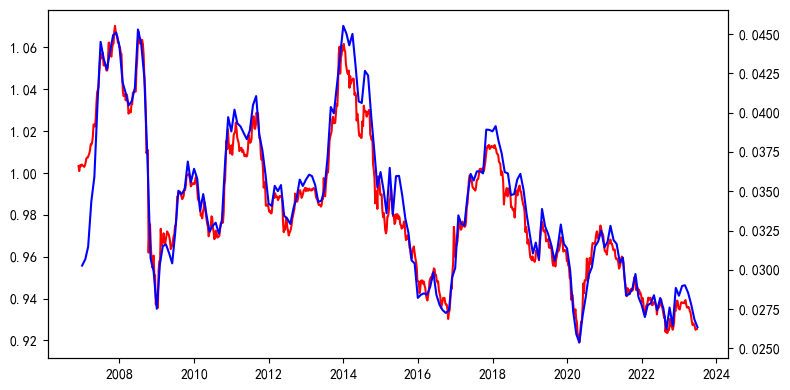

In [474]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(Inter_W.index, Inter_W['Interest'], 'r-', label='HF_Inter')
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Interest'], 'b-', label='RAW_Inter')

plt.tight_layout()
plt.show()

In [470]:
#Credit
# Credit_W = w.wsd("CBA04031.CS,CBA02531.CS", "close", "2006-12-22", "2023-06-30", "Period=W",usedf=True)[1].dropna()
Credit_W = Asset_price[['CBA04031_CS','CBA02531_CS']].loc[:'2023-06-30']
# 去趋势
from scipy.signal  import detrend 
# plt.plot(Credit_W)
Credit_W.dropna(inplace=True)
for column in Credit_W.columns: 
#     # 将结果添加到DataFrame 
    Credit_W[f'{column}'] = detrend(Credit_W[column])+Credit_W[column].mean()
# plt.plot(Credit_W)

Credit_W = -Credit_W.pct_change()
# plt.plot(Credit_W)
Credit_W['Credit_HF_'] = (Credit_W['CBA04031_CS'] - Credit_W['CBA02531_CS'])
# Credit_W.dropna(inplace=True)
# Credit_W['Credit_HF_'] = detrend(Credit_W['Credit_HF_'],type='linear')


Credit_W['Credit_HF'] = (1+Credit_W['Credit_HF_']).cumprod()


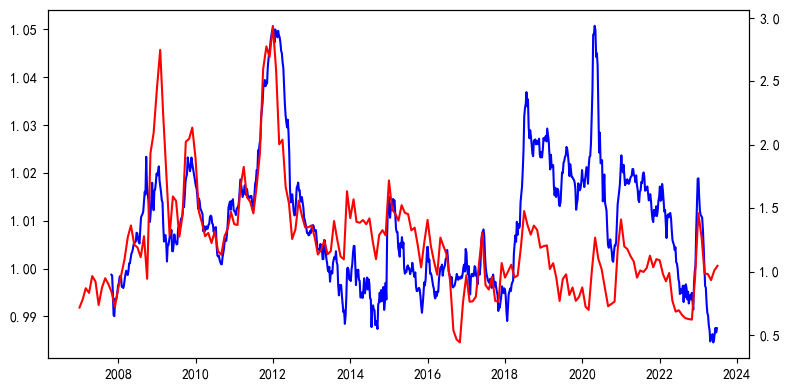

In [475]:
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(Credit_W.index, Credit_W['Credit_HF'], 'b-', label='HF_Credit')
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Credit'], 'r-', label='RAW_Inter')

plt.tight_layout()
plt.show()

## 增长、通胀、流动性

In [476]:
#增长
# g1 = w.edb("S0031510,S0105912,M0049225", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
g1 = Asset_price[['S0031510','S0105912','M0049225']]
g1.index = pd.to_datetime(g1.index)
g1 = g1.resample("W").last()
# g2 = w.wsd("HSI.HI", "close", "2006-06-22", "2023-06-30", "Period=W",usedf=True)[1].dropna()
g2 = Asset_price[['HSI_HI']]
g2.index = pd.to_datetime(g2.index)
g2.columns = ['HSI']
g2 = g2.resample("W").last()

In [477]:
grow_data = pd.concat([g1,g2],axis=1)
grow_data.to_csv("grow_data.csv")

In [478]:
#test
log_price = np.log(grow_data)
#同比
log_yoy = log_price - log_price.shift(52)
log_yoy = log_yoy.dropna()
print(f"对数同比序列：{log_yoy.shape}")
print(log_yoy.head())
#因子对齐
log_yoy_monthly = log_yoy.resample('M').last()
common_dates = Macro_raw_factor.index.intersection(log_yoy_monthly.index)
macro_monthly = Macro_raw_factor.loc[common_dates, 'Growth']
X_monthly = log_yoy_monthly.loc[common_dates, :]
print(X_monthly)

对数同比序列：(807, 4)
            S0031510  S0105912  M0049225       HSI
index                                             
2007-06-24  0.210997  0.124636  1.470343  0.330471
2007-07-01  0.210881  0.065596  1.355817  0.291482
2007-07-08  0.216794 -0.021922  1.320631  0.314005
2007-07-15  0.205437 -0.059770  1.335150  0.358767
2007-07-22  0.233510  0.101993  1.440032  0.346919
            S0031510  S0105912  M0049225       HSI
index                                             
2007-06-30  0.210997  0.124636  1.470343  0.330471
2007-07-31  0.218102  0.058281  1.540506  0.286075
2007-08-31  0.194157 -0.015047  1.697020  0.301503
2007-09-30  0.218054 -0.011514  1.507785  0.436442
2007-10-31  0.187385 -0.043626  1.518902  0.507847
...              ...       ...       ...       ...
2023-02-28 -0.143737  0.026135 -0.094959 -0.129086
2023-03-31 -0.195423 -0.011865 -0.148897 -0.072112
2023-04-30 -0.195115 -0.045788 -0.192657 -0.058323
2023-05-31 -0.180717 -0.068098 -0.210208 -0.098977
2023-06-30 -0.1

In [479]:
grow_data.corr()

,S0031510,S0105912,M0049225,HSI
S0031510,1.000000,0.871469,-0.060808,0.266327
S0105912,0.871469,1.000000,-0.107616,0.240069
M0049225,-0.060808,-0.107616,1.000000,0.622173
HSI,0.266327,0.240069,0.622173,1.000000


In [518]:
def product_HF_weights(price_data: pd.DataFrame,macro_factor_raw_name: str):
    #周频对数价格
    log_price = np.log(price_data)
    #同比
    log_yoy = log_price - log_price.shift(52)
    log_yoy = log_yoy.dropna()
    print(f"对数同比序列：{log_yoy.shape}")
    print(log_yoy.head())

    #因子对齐
    log_yoy_monthly = log_yoy.resample('M').last()
    common_dates = Macro_raw_factor.index.intersection(log_yoy_monthly.index)
    macro_monthly = Macro_raw_factor.loc[common_dates, macro_factor_raw_name]
    X_monthly = log_yoy_monthly.loc[common_dates, :]

    
    #领先滞后回归
    # 测试领先期范围（-6到6个月）
    asset_names = price_data.columns.tolist()
    lead_lags = range(0, 12) #lag代表Y相对于X领先多少期
    X_combined = pd.DataFrame()
    for asset in asset_names:
        print("-"*100)
        print(f"正在处理资产:{asset}")
        best_score = -np.inf
        best_lead_lag = 0
        best_model = None
        scores = []
        for lead_lag in lead_lags:
            # 调整Y的时间
            if lead_lag >= 0:
                y_shifted = macro_monthly.iloc[lead_lag:]
                X_shifted = X_monthly[asset].iloc[:-lead_lag] if lead_lag > 0 else X_monthly[asset]
            else:
                y_shifted = macro_monthly.iloc[:lead_lag]
                X_shifted = X_monthly[asset].iloc[-lead_lag:]
            
            # 对齐索引
            common_idx = y_shifted.index
            X_shifted.index = common_idx
            if len(common_idx) < 10:  # 至少需要10个样本
                continue
            
            y_aligned = y_shifted.loc[common_idx]
            X_aligned = X_shifted.loc[common_idx]

            # 线性回归
            model = LinearRegression()
            model.fit(pd.DataFrame(X_aligned), y_aligned)
            score = model.score(pd.DataFrame(X_aligned), y_aligned)
            scores.append(score)
            
            print(f"领先期={lead_lag:2d}月, R²={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_lead_lag = lead_lag
                best_model = model
                X_best = X_aligned
        print(f"\n最优领先期: {best_lead_lag}月, R²={best_score:.4f}")
        print(f"回归系数: {dict(zip(asset_names, best_model.coef_))}")
        X_combined = pd.concat([X_combined,X_best],axis=1)
    
    X_combined = X_combined.dropna()
    common_idx = X_combined.index
    y_combined = macro_monthly.loc[common_idx]
    #多元资产回归
    print("-"*60)
    print("开始多元资产回归")
    model_2 = LinearRegression()
    model_2.fit(X_combined,y_combined)
    score_2 = model_2.score(X_combined,y_combined)
    print(f"多元资产回归R²: {score_2:.4f}")
    print(f"回归系数: {dict(zip(asset_names, model_2.coef_))}")

    # 取绝对值后归一化（使权重和为1）
    weights_raw = np.abs(model_2.coef_)
    weights = weights_raw / weights_raw.sum()
    print("归一化权重:")
    for name, weight in zip(asset_names, weights):
        print(f"  {name}: {weight:.4f}")

    return weights,X_combined

In [519]:
weights,X = product_HF_weights(grow_data.loc['2007-10-15':],'Growth')

对数同比序列：(741, 4)
            S0031510  S0105912  M0049225       HSI
index                                             
2008-10-19 -0.263378 -0.466234 -1.132275 -0.705325
2008-10-26 -0.338004 -0.568260 -1.196506 -0.879460
2008-11-02 -0.356049 -0.614821 -1.364890 -0.779871
2008-11-09 -0.365496 -0.643488 -1.310748 -0.703503
2008-11-16 -0.376466 -0.569819 -1.094789 -0.712494
----------------------------------------------------------------------------------------------------
正在处理资产:S0031510
领先期= 0月, R²=0.2368
领先期= 1月, R²=0.1834
领先期= 2月, R²=0.1247
领先期= 3月, R²=0.0717
领先期= 4月, R²=0.0321
领先期= 5月, R²=0.0090
领先期= 6月, R²=0.0004
领先期= 7月, R²=0.0021
领先期= 8月, R²=0.0109
领先期= 9月, R²=0.0239
领先期=10月, R²=0.0366
领先期=11月, R²=0.0460

最优领先期: 0月, R²=0.2368
回归系数: {'S0031510': np.float64(0.11921631734887292)}
----------------------------------------------------------------------------------------------------
正在处理资产:S0105912
领先期= 0月, R²=0.2230
领先期= 1月, R²=0.1826
领先期= 2月, R²=0.1266
领先期= 3月, R²=0.0744
领先期= 4月, R²=0.0

In [516]:
# 
# 批量领先滞后
# def product_HF_weights(price_data: pd.DataFrame,macro_factor_raw_name: str):
#     #周频对数价格
#     log_price = np.log(price_data)
#     #同比
#     log_yoy = log_price - log_price.shift(52)
#     log_yoy = log_yoy.dropna()
#     print(f"对数同比收益率序列：{log_yoy.shape}")

#     #因子对齐
#     log_yoy_monthly = log_yoy.resample('M').last()
#     common_dates = Macro_raw_factor.index.intersection(log_yoy_monthly.index)
#     macro_monthly = Macro_raw_factor.loc[common_dates, macro_factor_raw_name]
#     X_monthly = log_yoy_monthly.loc[common_dates, :]

    
#     #领先滞后回归
#     # 测试领先期范围（-6到6个月）
#     asset_names = price_data.columns.tolist()
#     lead_lags = range(0, 7) #lag代表Y相对于X领先多少期
#     best_score = -np.inf
#     best_lead_lag = 0
#     best_model = None
#     scores = []

#     for lead_lag in lead_lags:
#         # 调整Y的时间
#         if lead_lag >= 0:
#             y_shifted = macro_monthly.iloc[lead_lag:]
#             X_shifted = X_monthly.iloc[:-lead_lag] if lead_lag > 0 else X_monthly
#         else:
#             y_shifted = macro_monthly.iloc[:lead_lag]
#             X_shifted = X_monthly.iloc[-lead_lag:]
        
#         # 对齐索引
#         common_idx = y_shifted.index
#         X_shifted.index = common_idx
#         if len(common_idx) < 10:  # 至少需要10个样本
#             continue
        
#         y_aligned = y_shifted.loc[common_idx]
#         X_aligned = X_shifted.loc[common_idx]
#         # 线性回归
#         model = LinearRegression()
#         model.fit(X_aligned, y_aligned)
#         score = model.score(X_aligned, y_aligned)
#         scores.append(score)
        
#         print(f"领先期={lead_lag:2d}月, R²={score:.4f}")
        
#         if score > best_score:
#             best_score = score
#             best_lead_lag = lead_lag
#             best_model = model

#     print(f"\n最优领先期: {best_lead_lag}月, R²={best_score:.4f}")
#     print(f"回归系数: {dict(zip(asset_names, best_model.coef_))}")
#     # 取绝对值后归一化（使权重和为1）
#     weights_raw = np.abs(best_model.coef_)
#     weights = weights_raw / weights_raw.sum()
#     print("归一化权重:")
#     for name, weight in zip(asset_names, weights):
#         print(f"  {name}: {weight:.4f}")
#     return weights

In [517]:
# weights = product_HF_weights(grow_data,'Growth')

对数环比序列: (887, 4)
            S0031510  S0105912  M0049225       HSI
index                                             
2006-07-02  0.004130  0.057728  0.035215  0.029022
2006-07-09  0.001770  0.114484  0.021774  0.011812
2006-07-16  0.016993  0.025065  0.047678 -0.019689
2006-07-23 -0.017223 -0.101484  0.024247  0.020357
2006-07-30  0.005800  0.029297 -0.012334  0.029814
高频Growth环比序列: (887,)
index
2006-07-02    0.015346
2006-07-09    0.011122
2006-07-16    0.005253
2006-07-23   -0.009023
2006-07-30    0.015010
Freq: W-SUN, dtype: float64
高频Growth因子: (818,)
index
2007-10-28    1.009151
2007-11-04    1.007789
2007-11-11    0.988181
2007-11-18    0.970692
2007-11-25    0.948667
Freq: W-SUN, dtype: float64


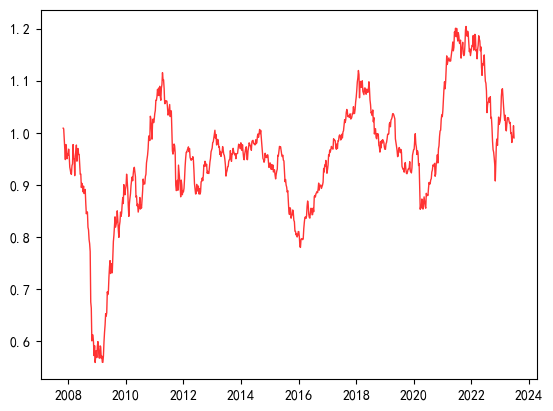

In [520]:
#计算周频资产的环比序列
price_mom = grow_data.pct_change()
price_mom = price_mom.dropna()
print(f"对数环比序列: {price_mom.shape}")
print(price_mom.head())
# 加权
high_freq_growth_mom = (price_mom * weights).sum(axis=1)
print(f"高频Growth环比序列: {high_freq_growth_mom.shape}")
print(high_freq_growth_mom.head())
#合成环比高频宏观因子
high_freq_growth_mom = high_freq_growth_mom.loc["2007-10-28":]
high_freq_growth = (1+high_freq_growth_mom).cumprod()
print(f"高频Growth因子: {high_freq_growth.shape}")
print(high_freq_growth.head())
#作图
plt.plot(high_freq_growth.index, 
            high_freq_growth, 
            label='高频Growth因子（周频）', 
            color='r',
            linewidth=1, 
            alpha=0.8)
growth_mom_ = high_freq_growth_mom
growth_mom_net = high_freq_growth

In [509]:
# kk = price_yoy*weights
# kk.plot()

同比序列: (836, 4)
            S0031510  S0105912  M0049225       HSI
index                                             
2007-06-24  0.234908  0.132736  3.350726  0.391623
2007-07-01  0.234765  0.067795  2.879930  0.338409
2007-07-08  0.242088 -0.021683  2.745784  0.368897
2007-07-15  0.228061 -0.058019  2.800567  0.431563
2007-07-22  0.263026  0.107376  3.220833  0.414701
高频Growth同比序列: (836,)
index
2007-06-24    0.289669
2007-07-01    0.267206
2007-07-08    0.276795
2007-07-15    0.287363
2007-07-22    0.312884
Freq: W-SUN, dtype: float64
高频Growth同比因子: (818,)
index
2007-10-28    0.353499
2007-11-04    0.338317
2007-11-11    0.286759
2007-11-18    0.261059
2007-11-25    0.219382
Freq: W-SUN, dtype: float64


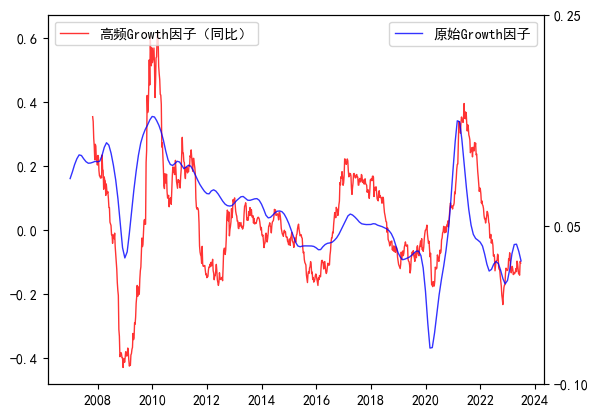

In [521]:
#同比序列

price_yoy = grow_data.pct_change(52)
price_yoy = price_yoy.dropna()
print(f"同比序列: {price_yoy.shape}")
print(price_yoy.head())
# 加权
high_freq_growth_yoy = (price_yoy * weights).sum(axis=1)
print(f"高频Growth同比序列: {high_freq_growth_yoy.shape}")
print(high_freq_growth_yoy.head())
#合成同比高频宏观因子
high_freq_growth_yoy = high_freq_growth_yoy.loc["2007-10-28":]
# high_freq_growth_yoy = (1+high_freq_growth_yoy).cumprod()
print(f"高频Growth同比因子: {high_freq_growth_yoy.shape}")
print(high_freq_growth_yoy.head())

#作图
#左右坐标轴

fig, ax1 = plt.subplots()   
ax2 = ax1.twinx()

ax1.plot(high_freq_growth_yoy.index, 
            high_freq_growth_yoy, 
            label='高频Growth因子（同比）', 
            linewidth=1, 
            color='r',
            alpha=0.8)
# ax1.set_yticks([-0.5, 0.8, 0.1])
ax2.plot(Macro_raw_factor['Growth'],label='原始Growth因子',linewidth=1,alpha=0.8,color='b')
ax2.set_yticks([-0.1, 0.25, 0.05])
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [522]:
#通胀
# inflation_data = w.edb("S0031525,S0143884,S0179664", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
inflation_data = Asset_price[['S0031525','S0143884','S0179664']]
inflation_data.index = pd.to_datetime(inflation_data.index)
inflation_data = inflation_data.resample("W").last()

In [524]:
inflation_data

,S0031525,S0143884,S0179664
index,,,
2006-06-25,69.93,NaN,NaN
2006-07-02,73.51,NaN,3092.0
2006-07-09,73.51,NaN,3092.0
2006-07-16,77.27,NaN,3021.0
2006-07-23,73.75,NaN,3021.0
...,...,...,...
2023-05-28,76.95,24.05,3900.0
2023-06-04,76.13,23.98,3861.0
2023-06-11,74.79,23.84,3915.0


In [49]:
weights = product_HF_weights(inflation_data,'Inflation')

对数同比序列：(728, 3)
            S0031525  S0143884  S0179664
2009-08-02 -0.549241 -0.334077 -0.244661
2009-08-09 -0.431795 -0.308095 -0.244661
2009-08-16 -0.441053 -0.267879 -0.287682
2009-08-23 -0.428867 -0.243541 -0.287682
2009-08-30 -0.449058 -0.224395 -0.287682
领先期=-6月, R²=0.1514
领先期=-5月, R²=0.1658
领先期=-4月, R²=0.1902
领先期=-3月, R²=0.2571
领先期=-2月, R²=0.3618
领先期=-1月, R²=0.5190
领先期= 0月, R²=0.6592
领先期= 1月, R²=0.7248
领先期= 2月, R²=0.7021
领先期= 3月, R²=0.6198
领先期= 4月, R²=0.5307
领先期= 5月, R²=0.4706
领先期= 6月, R²=0.4328

最优领先期: 1月, R²=0.7248
回归系数: {'S0031525': np.float64(0.02819581831828873), 'S0143884': np.float64(0.020693215935187612), 'S0179664': np.float64(0.04189249898988292)}
归一化权重:
  S0031525: 0.3106
  S0143884: 0.2279
  S0179664: 0.4615


对数环比序列: (779, 3)
            S0031525  S0143884  S0179664
2008-08-10 -0.087373  0.000000  0.000000
2008-08-17 -0.006883 -0.007719 -0.041005
2008-08-24  0.012172  0.000000  0.000000
2008-08-31  0.001141 -0.003264  0.000000
2008-09-07 -0.087330  0.000000 -0.018297
高频Growth环比序列: (779,)
2008-08-10   -0.027137
2008-08-17   -0.022819
2008-08-24    0.003781
2008-08-31   -0.000390
2008-09-07   -0.035567
Freq: W-SUN, dtype: float64
高频Growth因子: (779,)
2008-08-10    0.972863
2008-08-17    0.950663
2008-08-24    0.954257
2008-08-31    0.953885
2008-09-07    0.919958
Freq: W-SUN, dtype: float64


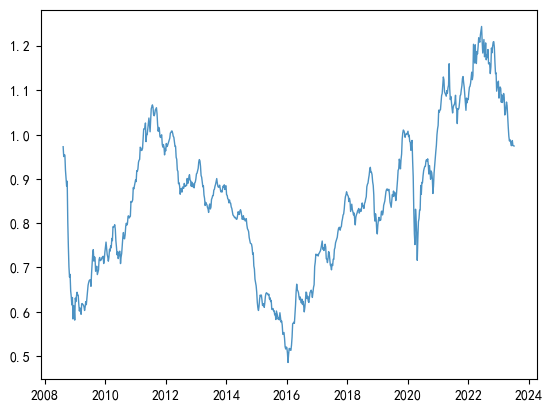

In [50]:
#计算周频资产的环比序列
price_mom = inflation_data.pct_change()
price_mom = price_mom.dropna()
print(f"对数环比序列: {price_mom.shape}")
print(price_mom.head())
# 加权
high_freq_mom = (price_mom * weights).sum(axis=1)
print(f"高频Growth环比序列: {high_freq_mom.shape}")
print(high_freq_mom.head())
#合成环比高频宏观因子
high_freq_mom = high_freq_mom.loc["2007-10-28":]
high_freq = (1+high_freq_mom).cumprod()
print(f"高频Growth因子: {high_freq.shape}")
print(high_freq.head())
#作图
plt.plot(high_freq.index, 
            high_freq, 
            label='高频Growth因子（周频）', 
            linewidth=1, 
            alpha=0.8)

infl_mom = high_freq_mom
infl_net = high_freq

同比序列: (728, 3)
            S0031525  S0143884  S0179664
2009-08-02 -0.422612 -0.284001  -0.21703
2009-08-09 -0.350657 -0.265154  -0.21703
2009-08-16 -0.356641 -0.235000  -0.25000
2009-08-23 -0.348754 -0.216152  -0.25000
2009-08-30 -0.361771 -0.201001  -0.25000
高频Growth同比序列: (728,)
2009-08-02   -0.296148
2009-08-09   -0.269503
2009-08-16   -0.279703
2009-08-23   -0.272956
2009-08-30   -0.273546
Freq: W-SUN, dtype: float64
高频Growth同比因子: (728,)
2009-08-02   -0.296148
2009-08-09   -0.269503
2009-08-16   -0.279703
2009-08-23   -0.272956
2009-08-30   -0.273546
Freq: W-SUN, dtype: float64


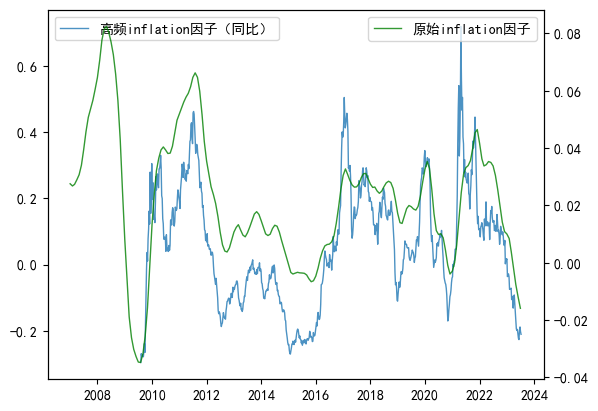

In [51]:
#同比序列

price_yoy = inflation_data.pct_change(52)
price_yoy = price_yoy.dropna()
print(f"同比序列: {price_yoy.shape}")
print(price_yoy.head())
# 加权
high_freq_yoy = (price_yoy * weights).sum(axis=1)
print(f"高频Growth同比序列: {high_freq_yoy.shape}")
print(high_freq_yoy.head())
#合成同比高频宏观因子
high_freq_yoy_1 = high_freq_yoy.loc["2007-10-28":]
print(f"高频Growth同比因子: {high_freq_yoy_1.shape}")
print(high_freq_yoy_1.head())

#作图
#左右坐标轴
fig, ax1 = plt.subplots()   
ax2 = ax1.twinx()

ax1.plot(high_freq_yoy_1.index, 
            high_freq_yoy_1, 
            label='高频inflation因子（同比）', 
            linewidth=1, 
            alpha=0.8)
ax2.plot(Macro_raw_factor['Inflation'],label='原始inflation因子',linewidth=1,alpha=0.8,color='g')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [52]:
#流动性因子
# 流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)
liquidity_data = w.edb("M0049385,M0049387", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
liquidity_data.index = pd.to_datetime(liquidity_data.index)
liquidity_data = liquidity_data.resample("W").last().dropna()

In [53]:
weights = product_HF_weights(liquidity_data,'Liquidity')

对数同比序列：(816, 2)
            M0049385  M0049387
2007-07-22  0.930839  0.490547
2007-07-29  0.973736  0.542788
2007-08-05  1.006508  0.479751
2007-08-12  1.075627  0.487405
2007-08-19  1.058597  0.485271
领先期=-6月, R²=0.2801
领先期=-5月, R²=0.2911
领先期=-4月, R²=0.2782
领先期=-3月, R²=0.2405
领先期=-2月, R²=0.1884
领先期=-1月, R²=0.1315
领先期= 0月, R²=0.0804
领先期= 1月, R²=0.0393
领先期= 2月, R²=0.0155
领先期= 3月, R²=0.0110
领先期= 4月, R²=0.0248
领先期= 5月, R²=0.0527
领先期= 6月, R²=0.0855

最优领先期: -5月, R²=0.2911
回归系数: {'M0049385': np.float64(-0.01740035764902072), 'M0049387': np.float64(0.07821659905887138)}
归一化权重:
  M0049385: 0.1820
  M0049387: 0.8180


对数环比序列: (867, 2)
            M0049385  M0049387
2006-07-02  0.040248  0.038621
2006-07-09  0.029762  0.126050
2006-07-16 -0.039017 -0.032836
2006-07-23  0.001003  0.004630
2006-07-30 -0.009014 -0.003264
高频Liquidity环比序列: (867,)
2006-07-02    0.038917
2006-07-09    0.108528
2006-07-16   -0.033961
2006-07-23    0.003970
2006-07-30   -0.004310
dtype: float64
高频Liquidity因子: (803,)
2007-10-28    0.911417
2007-11-04    0.925282
2007-11-11    0.884652
2007-11-18    0.888564
2007-11-25    0.893092
dtype: float64


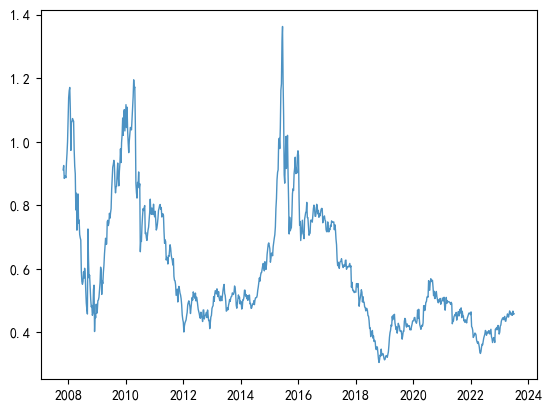

In [54]:
#计算周频资产的环比序列
price_mom = liquidity_data.pct_change()
price_mom = price_mom.dropna()
print(f"对数环比序列: {price_mom.shape}")
print(price_mom.head())
# 加权
high_freq_mom = (price_mom * weights).sum(axis=1)
print(f"高频Liquidity环比序列: {high_freq_mom.shape}")
print(high_freq_mom.head())
#合成环比高频宏观因子
high_freq_mom = high_freq_mom.loc["2007-10-28":]
high_freq = (1+high_freq_mom).cumprod()
print(f"高频Liquidity因子: {high_freq.shape}")
print(high_freq.head())
#作图
plt.plot(high_freq.index, 
            high_freq, 
            label='高频Liquidity因子（周频）', 
            linewidth=1, 
            alpha=0.8)
liqui_mom_ = high_freq_mom
liqui_net = high_freq

同比序列: (816, 2)
            M0049385  M0049387
2007-07-22  1.536636  0.633210
2007-07-29  1.647817  0.720798
2007-08-05  1.736031  0.615672
2007-08-12  1.931830  0.628086
2007-08-19  1.882323  0.624616
高频Growth同比序列: (816,)
2007-07-22    0.797615
2007-07-29    0.889497
2007-08-05    0.819554
2007-08-12    0.865341
2007-08-19    0.853493
dtype: float64
高频Growth同比因子: (803,)
2007-10-28    0.395716
2007-11-04    0.411844
2007-11-11    0.386464
2007-11-18    0.388403
2007-11-25    0.437747
dtype: float64


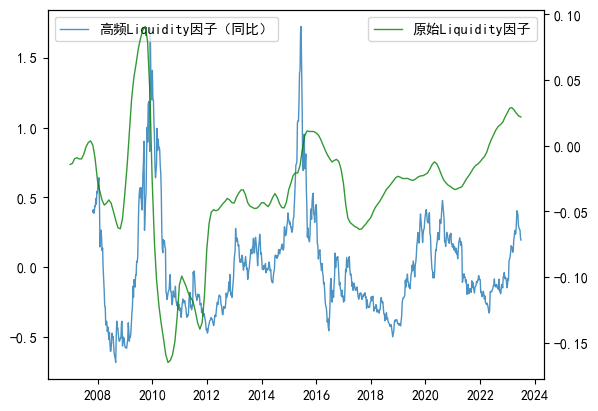

In [55]:
#同比序列

price_yoy = liquidity_data.pct_change(52)
price_yoy = price_yoy.dropna()
print(f"同比序列: {price_yoy.shape}")
print(price_yoy.head())
# 加权
high_freq_yoy_2 = (price_yoy * weights).sum(axis=1)
print(f"高频Growth同比序列: {high_freq_yoy_2.shape}")
print(high_freq_yoy_2.head())
#合成同比高频宏观因子
high_freq_yoy_2 = high_freq_yoy_2.loc["2007-10-28":]
print(f"高频Growth同比因子: {high_freq_yoy_2.shape}")
print(high_freq_yoy_2.head())

#作图
#左右坐标轴
fig, ax1 = plt.subplots()   
ax2 = ax1.twinx()

ax1.plot(high_freq_yoy_2.index, 
            high_freq_yoy_2, 
            label='高频Liquidity因子（同比）', 
            linewidth=1, 
            alpha=0.8)
ax2.plot(Macro_raw_factor['Liquidity'],label='原始Liquidity因子',linewidth=1,alpha=0.8,color='g')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [36]:
Credit_W['Credit_HF']

2007-10-26    0.998087
2007-11-02    0.997699
2007-11-09    0.992919
2007-11-16    0.986356
2007-11-23    0.985990
                ...   
2023-06-02    0.995729
2023-06-09    0.996627
2023-06-16    0.995931
2023-06-21    0.996536
2023-06-30    0.997866
Name: Credit_HF, Length: 803, dtype: float64

## 数据存储

In [112]:
#同比组合
Credit_W.index = pd.to_datetime(Credit_W.index)
Credit_W = Credit_W.resample("W").last()
Inter_W_.index = pd.to_datetime(Inter_W_.index)
Inter_W_ = Inter_W_.resample("W").last()
high_freq_growth_yoy.index = pd.to_datetime(high_freq_growth_yoy.index)
high_freq_yoy_1.index = pd.to_datetime(high_freq_yoy_1.index)
high_freq_yoy_2.index = pd.to_datetime(high_freq_yoy_2.index)


In [113]:
Exchange_W = w.edb("M0000271",
                    "2006-06-01", 
                    "2023-06-01",
                    "Fill=Previous",
                    "Period=W",
                    usedf=True)[1]
Exchange_W = Exchange_W.pct_change().dropna()
Exchange_W.columns = ['Exchange_HF']
Exchange_W.index = pd.to_datetime(Exchange_W.index)
Exchange_W = Exchange_W.resample("W").last()

In [114]:
Macro_HF_yoy = pd.concat([Credit_W['Credit_HF_'],Inter_W_['Interest'],Exchange_W['Exchange_HF'],high_freq_growth_yoy,high_freq_yoy_1,high_freq_yoy_2],axis=1) 

In [115]:
Macro_HF_yoy.columns = ['Credit_HF','Interest_HF','Exchange_HF','Growth_HF','Inflation_HF','Liquidity_HF']
Macro_HF_yoy.fillna(method='ffill',inplace=True)

In [116]:
Macro_HF_yoy

,Credit_HF,Interest_HF,Exchange_HF,Growth_HF,Inflation_HF,Liquidity_HF
2006-06-11,NaN,NaN,0.020469,NaN,NaN,NaN
2006-06-18,NaN,NaN,0.002216,NaN,NaN,NaN
2006-06-25,NaN,NaN,0.010822,NaN,NaN,NaN
2006-07-02,NaN,NaN,-0.019685,NaN,NaN,NaN
2006-07-09,NaN,NaN,-0.001761,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-06-11,0.000902,-0.001604,-0.006351,-0.137831,-0.226928,0.270421
2023-06-18,-0.000698,0.000319,-0.006351,-0.097981,-0.199309,0.266082
2023-06-25,0.000607,0.000074,-0.006351,-0.091781,-0.188680,0.207286
2023-07-02,0.001335,-0.001924,-0.006351,-0.088960,-0.202949,0.194483


In [117]:
#环比组合
# growth_mom_ = high_freq_growth_mom
# growth_mom_net = high_freq_growth
# infl_mom = high_freq_mom
# infl_net = high_freq
# liqui_mom_ = high_freq_mom
# liqui_net = high_freq

growth_mom_.index = pd.to_datetime(growth_mom_.index)
infl_mom.index = pd.to_datetime(infl_mom.index)
liqui_mom_.index = pd.to_datetime(liqui_mom_.index)

growth_mom_net.index = pd.to_datetime(growth_mom_net.index)
infl_net.index = pd.to_datetime(infl_net.index)
liqui_net.index = pd.to_datetime(liqui_net.index)

Macro_HF_mom_1 = pd.concat([Credit_W['Credit_HF_'],Inter_W_['Interest'],Exchange_W['Exchange_HF'],growth_mom_,infl_mom,liqui_mom_],axis=1) 
Macro_HF_mom_1.columns = ['Credit_HF','Interest_HF','Exchange_HF','Growth_HF','Inflation_HF','Liquidity_HF']
Macro_HF_mom_1.fillna(method='ffill',inplace=True)

Macro_HF_mom_2 = pd.concat([Credit_W['Credit_HF_'],Inter_W_['Interest'],Exchange_W['Exchange_HF'],growth_mom_net,infl_net,liqui_net],axis=1) 
Macro_HF_mom_2.columns = ['Credit_HF','Interest_HF','Exchange_HF','Growth_HF','Inflation_HF','Liquidity_HF']
Macro_HF_mom_2.fillna(method='ffill',inplace=True)
Macro_HF_mom_2

,Credit_HF,Interest_HF,Exchange_HF,Growth_HF,Inflation_HF,Liquidity_HF
2006-06-11,NaN,NaN,0.020469,NaN,NaN,NaN
2006-06-18,NaN,NaN,0.002216,NaN,NaN,NaN
2006-06-25,NaN,NaN,0.010822,NaN,NaN,NaN
2006-07-02,NaN,NaN,-0.019685,NaN,NaN,NaN
2006-07-09,NaN,NaN,-0.001761,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-06-11,0.000902,-0.001604,-0.006351,1.058490,0.975265,0.453497
2023-06-18,-0.000698,0.000319,-0.006351,1.077853,0.986762,0.466615
2023-06-25,0.000607,0.000074,-0.006351,1.056857,0.975795,0.456405
2023-07-02,0.001335,-0.001924,-0.006351,1.055877,0.975061,0.458131


In [118]:
#initial_factor
with easy_manager.EasyManager(database='macro_data_base') as em:
    #初始宏观因子(月频)
    em.create_table('macro_intial_data_monthly',macro_data_M,overwrite=True)
    #原始宏观组合因子(月频)
    em.create_table('macro_raw_con_data_monthly',Macro_raw_factor,overwrite=True)
    #高频宏观因子(周频)
    em.create_table('macro_high_freq_data_weekly_yoy',Macro_HF_yoy,overwrite=True)
    #高频宏观因子（环比周频）
    em.create_table('macro_high_freq_data_weekly_mom_1',Macro_HF_mom_1,overwrite=True)
    em.create_table('macro_high_freq_data_weekly_mom_2',Macro_HF_mom_2,overwrite=True)
    


2025-11-13 15:48:53 | INFO | 数据库连接成功: macro_data_base
2025-11-13 15:48:53 | INFO | [Function: create_table started...]
2025-11-13 15:48:53 | INFO | 已删除现有表 macro_intial_data_monthly
2025-11-13 15:48:53 | INFO | 表 macro_intial_data_monthly 创建成功，包含 18 列
2025-11-13 15:48:53 | INFO | 成功插入 205 行数据到表 macro_intial_data_monthly
2025-11-13 15:48:53 | INFO | [Function: create_table completed, elapsed time: 0.07s]
2025-11-13 15:48:53 | INFO | [Function: create_table started...]
2025-11-13 15:48:53 | INFO | 已删除现有表 macro_raw_con_data_monthly
2025-11-13 15:48:53 | INFO | 表 macro_raw_con_data_monthly 创建成功，包含 7 列
2025-11-13 15:48:53 | INFO | 成功插入 199 行数据到表 macro_raw_con_data_monthly
2025-11-13 15:48:53 | INFO | [Function: create_table completed, elapsed time: 0.02s]
2025-11-13 15:48:53 | INFO | [Function: create_table started...]
2025-11-13 15:48:53 | INFO | 已删除现有表 macro_high_freq_data_weekly_yoy
2025-11-13 15:48:53 | INFO | 表 macro_high_freq_data_weekly_yoy 创建成功，包含 7 列
2025-11-13 15:48:53 | INFO | 成功插

# 因子暴露计算

In [4]:
with easy_manager.EasyManager(database='macro_data_base') as em:
    HF_macro_factor = em.load_table("macro_high_freq_data_weekly_mom_1")
    HF_macro_factor.set_index("index",inplace=True)
    HF_macro_factor.index = pd.to_datetime(HF_macro_factor.index)

2025-11-17 10:00:22 | INFO | 数据库连接成功: macro_data_base
2025-11-17 10:00:22 | INFO | [Function: load_table started...]
2025-11-17 10:00:22 | INFO | 成功从表 macro_high_freq_data_weekly_mom_1 加载数据，形状: (892, 7)
2025-11-17 10:00:22 | INFO | [Function: load_table completed, elapsed time: 0.05s]
2025-11-17 10:00:22 | INFO | 数据库连接已关闭


In [5]:
(HF_macro_factor.dropna(inplace=True))
HF_macro_factor = HF_macro_factor.loc[:"2023-05-30"]
HF_macro_factor.tail(10)

,Credit_HF,Interest_HF,Exchange_HF,Growth_HF,Inflation_HF,Liquidity_HF
index,,,,,,
2023-03-26,-0.001371,0.000348,-0.007295,0.014474,0.001564,0.023049
2023-04-02,-0.000277,-0.000424,-0.004937,0.005956,0.014810,0.007994
2023-04-09,-0.001501,0.000154,-0.004793,0.000179,0.011271,0.021889
2023-04-16,-0.000560,-0.001869,-0.005169,0.002552,-0.007545,-0.008439
2023-04-23,-0.001639,-0.000736,0.001404,-0.008652,-0.025081,-0.013693
2023-04-30,0.000814,-0.002508,-0.000547,-0.005087,-0.021159,0.019648
2023-05-07,0.000534,-0.002369,-0.003680,0.002282,-0.019932,0.023233
2023-05-14,0.000294,-0.001626,0.013956,-0.021487,-0.010735,-0.018429
2023-05-21,-0.001270,0.000903,0.004752,0.001202,0.002783,0.006093


In [6]:
def calculate_factor_stats(df):
    """
    计算因子相关系数矩阵和方差膨胀系数(VIF)
    
    参数:
    df : DataFrame, 索引为时间, 列为因子值 
    
    返回:
    corr_matrix : 因子相关系数矩阵 
    vif_series : 每个因子的VIF值序列 
    """
    # ===== 1. 预处理 =====
    df_clean = df.dropna()   # 删除缺失值
    if len(df_clean) < 2:
        raise ValueError("样本量不足，至少需要2个非缺失观测值")
    
    # ===== 2. 计算相关系数矩阵 =====
    corr_matrix = df_clean.corr() 
    
    # ===== 3. 计算VIF =====
    vif_data = []
    factors = df_clean.columns.tolist() 
    
    for i, factor in enumerate(factors):
        # 提取其他因子作为自变量 (排除当前因子)
        X = df_clean.drop(columns=factor) 
        y = df_clean[factor]
        
        # 添加常数项并拟合OLS模型
        X_sm = sm.add_constant(X) 
        model = sm.OLS(y, X_sm).fit()
        
        # 计算VIF (避免R²=1导致除零错误)
        r_squared = model.rsquared  
        vif = 1 / (1 - r_squared) if r_squared < 1 else np.inf 
        vif_data.append(vif) 
    
    vif_series = pd.Series(vif_data, index=factors, name='VIF')
    
    return corr_matrix, vif_series 
 
# 执行计算
correlation_matrix, vif_results = calculate_factor_stats(HF_macro_factor)
 
# ===== 结果展示 ===== 
print("="*50)
print("因子相关系数矩阵:")
print(correlation_matrix.round(2)) 
 
print("\n" + "="*50)
print("方差膨胀系数(VIF):")
print(vif_results.round(1)) 

因子相关系数矩阵:
              Credit_HF  Interest_HF  Exchange_HF  Growth_HF  Inflation_HF  \
Credit_HF          1.00        -0.28        -0.09      -0.03         -0.03   
Interest_HF       -0.28         1.00         0.02       0.26          0.22   
Exchange_HF       -0.09         0.02         1.00      -0.37         -0.22   
Growth_HF         -0.03         0.26        -0.37       1.00          0.43   
Inflation_HF      -0.03         0.22        -0.22       0.43          1.00   
Liquidity_HF      -0.01         0.10        -0.03       0.31          0.07   

              Liquidity_HF  
Credit_HF            -0.01  
Interest_HF           0.10  
Exchange_HF          -0.03  
Growth_HF             0.31  
Inflation_HF          0.07  
Liquidity_HF          1.00  

方差膨胀系数(VIF):
Credit_HF       1.1
Interest_HF     1.2
Exchange_HF     1.2
Growth_HF       1.6
Inflation_HF    1.3
Liquidity_HF    1.1
Name: VIF, dtype: float64


In [7]:
#资产价格
# price_df = w.wsd("000016.SH,000300.SH,000905.SH,000852.SH,HSI.HI,CBA00601.CS,CBA02001.CS,000832.CSI,NH0200.NHF,NH0300.NHF,B.IPE,AU9999.SGE,SPX.GI,USDCNH.FX", 
#             "close", 
#             "2006-10-13", 
#             "2025-11-11", 
#             usedf=True)[1]
with easy_manager.EasyManager(database='price_data_base') as em:
#     em.create_table('allocation_pool_1_price_daily',price_df,overwrite=True)
    price_df = em.load_table('allocation_pool_1_price_daily')
    price_df.set_index("index",inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

2025-11-17 10:00:38 | INFO | 数据库连接成功: price_data_base
2025-11-17 10:00:38 | INFO | [Function: load_table started...]
2025-11-17 10:00:38 | INFO | 成功从表 allocation_pool_1_price_daily 加载数据，形状: (4638, 15)
2025-11-17 10:00:38 | INFO | [Function: load_table completed, elapsed time: 0.10s]
2025-11-17 10:00:38 | INFO | 数据库连接已关闭


In [8]:
price_W_df = price_df.resample('W').last()
ret_W_df = price_W_df.pct_change().dropna()


C:\Users\28054\AppData\Local\Temp\ipykernel_2192\260388313.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_W_df = price_W_df.pct_change().dropna()


In [9]:
#日期序列对齐：
def index_common(df1,df2):
    common_idx = df1.index.intersection(df2.index)
    index_df1_only = df1.index.difference(df2.index)
    index_df2_only = df2.index.difference(df1.index)
    df1 = df1.loc[common_idx]
    df2 = df2.loc[common_idx]
    print(f"df1中存在但df2中不存在的日期: {index_df1_only}")
    print(f"df2中存在但df1中不存在的日期: {index_df2_only}")
    return df1,df2

In [10]:
HF_macro_factor,ret_W_df = index_common(HF_macro_factor,ret_W_df)


df1中存在但df2中不存在的日期: DatetimeIndex(['2008-08-10', '2008-08-17', '2008-08-24', '2008-08-31',
               '2008-09-07', '2008-09-14', '2008-09-21', '2008-09-28',
               '2008-10-05', '2008-10-12',
               ...
               '2012-03-04', '2012-03-11', '2012-03-18', '2012-03-25',
               '2012-04-01', '2012-04-08', '2012-04-15', '2012-04-22',
               '2012-04-29', '2012-05-06'],
              dtype='datetime64[ns]', name='index', length=196, freq=None)
df2中存在但df1中不存在的日期: DatetimeIndex(['2023-06-04', '2023-06-11', '2023-06-18', '2023-06-25',
               '2023-07-02', '2023-07-09', '2023-07-16', '2023-07-23',
               '2023-07-30', '2023-08-06',
               ...
               '2025-09-14', '2025-09-21', '2025-09-28', '2025-10-05',
               '2025-10-12', '2025-10-19', '2025-10-26', '2025-11-02',
               '2025-11-09', '2025-11-16'],
              dtype='datetime64[ns]', name='index', length=129, freq='W-SUN')


In [11]:
HF_macro_factor

,Credit_HF,Interest_HF,Exchange_HF,Growth_HF,Inflation_HF,Liquidity_HF
index,,,,,,
2012-05-13,-0.001532,-0.003096,0.009433,-0.018572,-0.004729,-0.011344
2012-05-20,0.001361,-0.009756,0.010341,-0.025023,-0.025787,-0.020200
2012-05-27,-0.003715,-0.004942,0.016155,-0.008253,-0.002858,-0.006955
2012-06-03,-0.005317,0.002889,0.005947,-0.007665,-0.030400,0.032260
2012-06-10,-0.008982,-0.001723,-0.004584,-0.002244,0.001986,-0.047288
...,...,...,...,...,...,...
2023-04-30,0.000814,-0.002508,-0.000547,-0.005087,-0.021159,0.019648
2023-05-07,0.000534,-0.002369,-0.003680,0.002282,-0.019932,0.023233
2023-05-14,0.000294,-0.001626,0.013956,-0.021487,-0.010735,-0.018429


In [12]:
#回归系数
import statsmodels.api as sm


def exposure_cal(date):
    print(f"计算{date}的因子暴露")
    exposures_df = pd.DataFrame(index=ret_W_df.columns, columns=HF_macro_factor.columns)
    HF_macro_factor_date = HF_macro_factor.loc[:date].iloc[-520:]
    ret_W_df_date = ret_W_df.loc[:date].iloc[-520:]
    R2_dict = {}
    for asset in ret_W_df.columns:
        R2_list = []
        if asset == 'CBA00601_CS' or asset == 'CBA02001_CS':
            params_list = np.zeros([3000,6])
            for i in range(3000):
                random_initial = np.random.randint(0,len(HF_macro_factor_date)-104)
                HF_macro_factor_date_random = HF_macro_factor_date.iloc[random_initial:random_initial+104]
                ret_W_df_date_random = ret_W_df_date.iloc[random_initial:random_initial+104]
                Y = ret_W_df_date_random[asset].values
                X = HF_macro_factor_date_random.values
                X = sm.add_constant(X)
                model = sm.OLS(Y, X).fit()
                params_list[i] = model.params[1:]
                R2_list.append(model.rsquared)
            R2_dict[asset] = np.mean(R2_list)
            exposures_df.loc[asset] = params_list.mean(axis=0)
        else:
            params_list = np.zeros([3000,5])
            for i in range(3000):
                random_initial = np.random.randint(0,len(HF_macro_factor_date)-104)
                HF_macro_factor_date_random = HF_macro_factor_date.iloc[random_initial:random_initial+104,1:]
                ret_W_df_date_random = ret_W_df_date.iloc[random_initial:random_initial+104]

                Y = ret_W_df_date_random[asset].values
                X = HF_macro_factor_date_random.values

                
                X = sm.add_constant(X)
                model = sm.OLS(Y, X).fit()
                params_list[i] = model.params[1:]
                R2_list.append(model.rsquared)
            R2_dict[asset] = np.mean(R2_list)

            # print(np.append(0,params_list.mean(axis=0)))
            exposures_df.loc[asset] = np.append(0,params_list.mean(axis=0))
    return exposures_df,R2_dict


In [ ]:
exposures_df,R2_dict = exposure_cal('2023-05-31')

计算2023-05-30的因子暴露


In [14]:
exposures_df.to_excel("exposure_df_20230530.xlsx")

In [15]:
exposures_df

,Credit_HF,Interest_HF,Exchange_HF,Growth_HF,Inflation_HF,Liquidity_HF
000016_SH,0.0,0.33499,0.012231,0.931443,-0.048341,0.309438
000300_SH,0.0,0.231499,-0.020764,0.750303,-0.060671,0.449427
000905_SH,0.0,0.082898,0.030063,0.265532,-0.027962,0.753187
000852_SH,0.0,0.004313,-0.018245,0.098908,-0.054352,0.867178
HSI_HI,0.0,0.152652,-0.105748,1.500062,-0.008674,0.080564
CBA00601_CS,-0.009102,-0.976724,-0.001187,-0.001707,0.000399,0.00056
CBA02001_CS,-0.472896,-0.582979,0.001339,0.003567,-0.006492,0.001024
000832_CSI,0.0,-0.486257,-0.044174,0.236738,-0.172899,0.315221
NH0200_NHF,0.0,0.110562,0.042478,1.114436,0.306325,-0.060214
NH0300_NHF,0.0,-0.100502,0.000719,0.298523,0.118299,-0.012825


# 确定目标因子暴露

In [ ]:
'''
设计一个函数，主要用于嵌套资产的权重 weight_nest.py
'''


In [16]:
'''
进行资产配置时往往存在一个基准组合，投资者根据自身对宏观经济的判断在基准组合的因子暴露之上进行主动偏离，以获取超额收益。
'''
#恒定组合基准
benchmark_portfolio={
    '000300_SH':0.1,
    '000905_SH':0.1,
    'CBA00601_CS':0.2,
    'CBA02001_CS':0.2,
    '000832_CSI':0.1,
    'NH0200_NHF':0.05,
    'NH0300_NHF':0.05,
    'B_IPE':0.05,
    'AU9999_SGE':0.1,
    'USDCNH_FX':0.05
    
}

In [40]:

asset_bench = np.array(list(benchmark_portfolio.keys()))
ret_W_df = ret_W_df[asset_bench]
weight_bench=np.matrix(list(benchmark_portfolio.values()))


In [41]:
from joblib import Parallel, delayed 

cal_date_list = HF_macro_factor.resample('M').last().index[36:]
# 初始化 DataFrame 
bench_exposure = pd.DataFrame(index=cal_date_list, columns=HF_macro_factor.columns) 
 
# 定义处理单个日期的函数
def process_date(date):
    exposures_df, _ = exposure_cal(date)  # 忽略 R2_dict
    return date, weight_bench * exposures_df.loc[asset_bench].values  
 
# 并行计算（n_jobs=-1 使用所有CPU核心）
results = Parallel(n_jobs=-1)(
    delayed(process_date)(date) 
    for date in cal_date_list[36:]
)
 
# 填充结果
for date, values in results:
    bench_exposure.loc[date]  = values

C:\Users\28054\AppData\Local\Temp\ipykernel_2192\3723314090.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cal_date_list = HF_macro_factor.resample('M').last().index[36:]


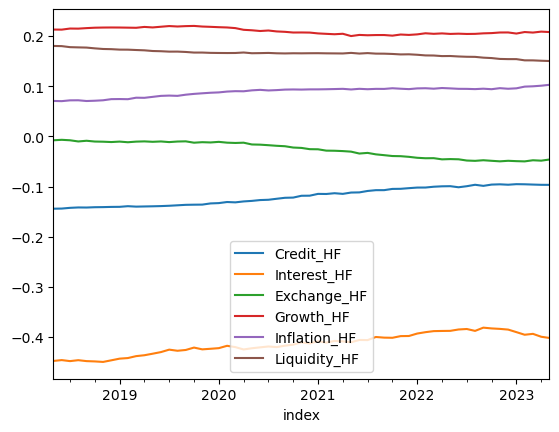

In [42]:
bench_exposure.dropna().plot()
bench_exposure.to_csv("./test_data/bench_exposure.csv")

In [1]:
# from Util_Fin import RP_solo_ver2_3
#使用风险平价策略作为基准？研报上说这回过多的暴露利率因子，暴露值的波动也会较大。

# 匹配因子的目标暴露

最优化目标:
$$
\argmin_{w} \Delta w'\Sigma \Delta w + (1-\lambda) ||w^TB_{N \times K}-T||_2 \\

s.t. \sum_{t=1}^N w_i = 1 \\
0 <w_i<1;-1<\Delta w_i<1



$$

In [32]:
import cvxpy as cp

In [ ]:
#以2023-05-30为基准，匹配因子暴露
B,R2_dict  = exposure_cal('2023-05-31')
B = B.values

计算2023-05-31的因子暴露


## 做多增长因子

In [98]:
#凸优化
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0,0.05,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

In [99]:
result= problem.solve()

In [101]:
w.value

array([0.12753562, 0.08380723, 0.22119192, 0.2011011 , 0.10558526,
       0.07714486, 0.04200205, 0.04700453, 0.08179041, 0.01283702])

In [103]:
dw = (w.value - w0)

<BarContainer object of 10 artists>

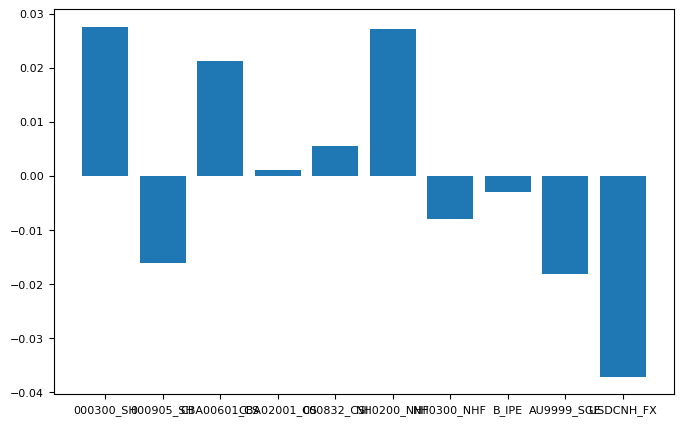

In [109]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)

在该策略组合下，因为认为未来经济会上行，那么策略会减配中证500，南华农产品以及美元，同时增配南华工业品，沪深300和国债。其中，中证500和国债的变动并不是直接受宏观因子变动而产生的，其本质是为了平衡其他因子暴露不变而进行的调整。

因子配置框架的目标是给定一个整体性的配置方案，只要求最终的组合暴露符合目标，并不能保证每种资产的权重都按照主观逻辑进行调整。

## 做多通胀因子

In [110]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0,0,0.05,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

In [111]:
result= problem.solve()

<BarContainer object of 10 artists>

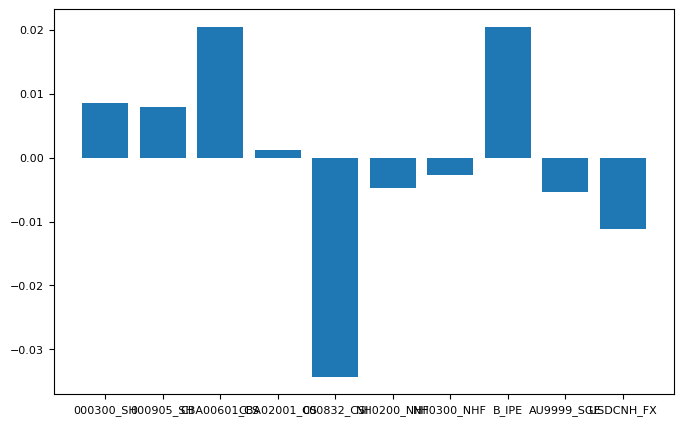

In [112]:
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)

## 做多利率因子

In [114]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0.05,0,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

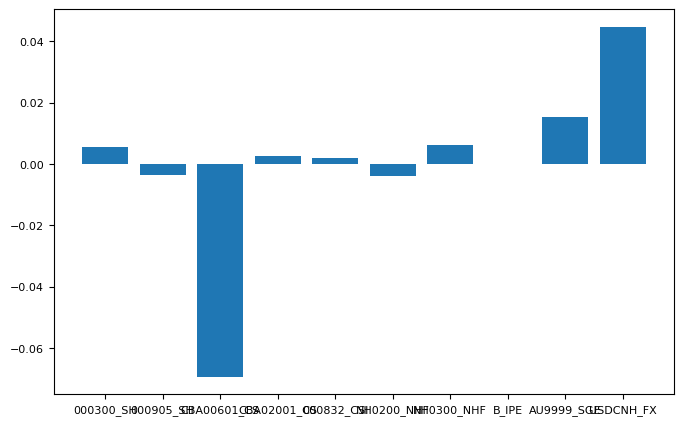

In [115]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


## 做多信用因子

In [116]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0.05,0,0,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

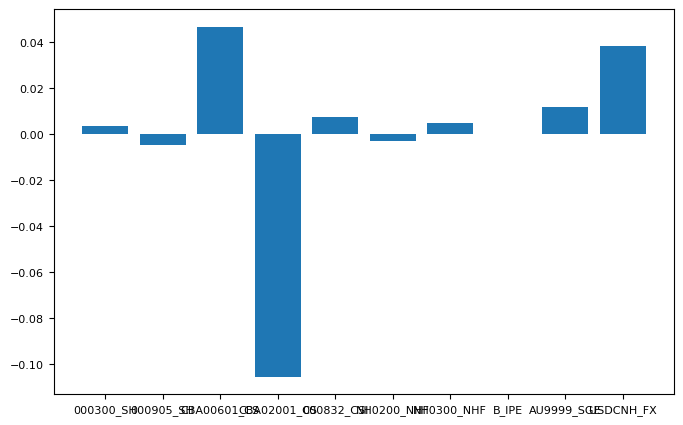

In [117]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


## 做多汇率因子

In [119]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0.05,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

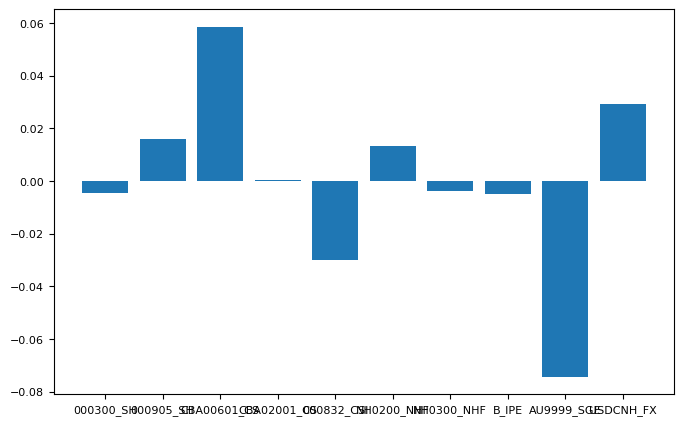

In [120]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


## 做多流动性因子

In [121]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0,0,0,0.05])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

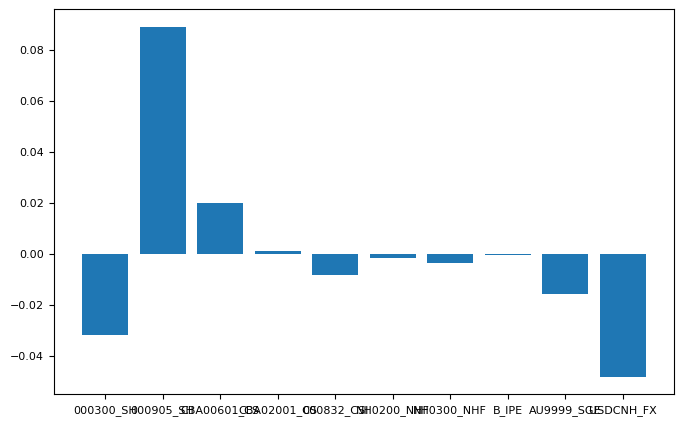

In [122]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)